Start

In [2]:
# using MorporJ
include("../src/MorporJ.jl")
using LinearAlgebra
using Test
using Plots
#using Surrogates
using Interpolations
using HDF5
using PyCall
@pyimport h5py


Import snapshots

In [3]:
fid = h5open("../snapshots/data_snapshots_onlymu_nomu1.h5", "r")
A=[]
exponent=2
mu_ratio=[10,20,30,40,50,60,70,80,90,100]
#dset=zeros(size(mu_ratio,1),size(exponent,1));
for j=1:size(mu_ratio,1)
#     for i=1:size(exponent,1)
        g=read(fid, "snap_mu_$(mu_ratio[j])")
        dset = g["snap_exp_$(exponent)"]
        push!(A,dset')
#     end
end
S=hcat([A[i] for i in 1:length(A)]...)
Nx=size(S,1)
Ns=size(S,2)
println(size(S))
close(fid)

(1000, 500)


In [4]:
close(fid)

Import final time

In [5]:
f2 = h5py.File("../snapshots/data_snapshots_onlymu_nomu1.h5", "r")
group2 = f2.get("snap_mu_10")
dataset2=group2.get("snap_exp_2")
print(dataset2.attrs.items())
tempo=zero(Int64)
for item in dataset2.attrs.items()
    print(item)
    if item[1]=="Years of simulation"
        tempo=parse(Int64, item[2])
        print(tempo)
    end
end
f2.close()

PyObject ItemsViewHDF5(<Attributes of HDF5 object at 140451279346680>)("Exponent of Relative Permeability Law", "2")("Horizontal Length", "0 - 1000")("Injector Pressure", "41370000")("Injector Wetting Saturation", "1")("NonWetting Viscosity", "0.03")("Number of mesh cells", "1000")("Permeability", "0")("Producer Pressure", "27580000")("Residual NonWetting Saturation", "0")("Residual Wetting Saturation", "0")("Rock Porosity", "0")("Vertical Height", "0 - 1")("Viscosities Ratio", "10")("Well Radius", "0")("Well Skin", "0")("Wetting Viscosity", "0")("Years of simulation", "5")5

In [6]:
tempo=5

5

In [7]:
N,Nₜₚ = size(S)
nₜₚ = size(S)[2] #number of kept snapshots
M = N
param=length(exponent)*length(mu_ratio)
nₛ₁=Int(nₜₚ/param)
deltat=round(tempo/nₛ₁,digits = 2)

0.1

Compute cdf, icdf

In [8]:
xgrid = collect(range(0, 1, length = N)) 
pgrid = collect(range(0, 1, length = M))

Δx = xgrid[2] - xgrid[1]

# normalize
S₁ = zero(S)
for i in 1:nₜₚ
    S₁[:,i] .= S[:,i]/(sum(S[:,i])*Δx)
end

In [323]:
s_pdf = [S₁[:,i] for i in 1:nₜₚ]

s_cdf = [zeros(N) for _ in 1:nₜₚ]

# for i in eachindex(s_pdf)
#     MorporJ.cdf!(s_cdf[i], s_pdf[i], Δx)
# end

s = [zeros(M) for _ in 1:nₜₚ]

for i in eachindex(s_cdf)
    MorporJ.cdf!(s_cdf[i], S₁[:,i], Δx)
    MorporJ.icdf!(s[i], s_cdf[i], xgrid, pgrid)
end

Find first basis

In [324]:
D=zeros(nₜₚ,nₜₚ)
for i in 1:nₜₚ
    for j in 1:nₜₚ
        D[i,j]=norm(s[i]-s[j],2)
    end
end
argmax(D)

CartesianIndex(500, 1)

In [325]:
maxD=Tuple(argmax(D))
minD=Tuple(argmin(D))
a = [s[maxD[2]], s[maxD[1]]];
# a = [s[i] for i in maxD];
n = length(a)

2

In [326]:
Λ, ΔW = MorporJ.barycenter_fit(s, a, Δx);

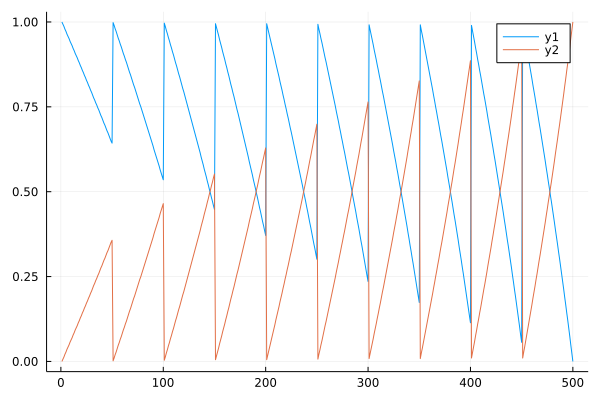

In [327]:
p = plot([Λ[i][1] for i in eachindex(Λ)] )
for j in 2:n
    plot!([Λ[i][j] for i in eachindex(Λ)] )
end
p

In [328]:
sᵣ = [zeros(M) for i in 1:nₜₚ]
for j in 1:nₜₚ
    for i in 1:n
        sᵣ[j] .+= Λ[j][i] .* a[i] # u approx
    end
end
sᵣ_cdf = [zeros(N) for i in 1:nₜₚ]
sᵣ_pdf = [zeros(N) for i in 1:nₜₚ]

sₑ_cdf = [zeros(N) for i in 1:nₜₚ]
sₑ_pdf = [zeros(N) for i in 1:nₜₚ]

for j in 1:nₜₚ
    MorporJ.iicdf!(sᵣ_cdf[j], sᵣ[j], xgrid, pgrid)
    MorporJ.cdf_to_pdf!(sᵣ_pdf[j], sᵣ_cdf[j], Δx; order=1)
    MorporJ.iicdf!(sₑ_cdf[j], s[j], xgrid, pgrid)
    MorporJ.cdf_to_pdf!(sₑ_pdf[j], sₑ_cdf[j], Δx; order=1)
end


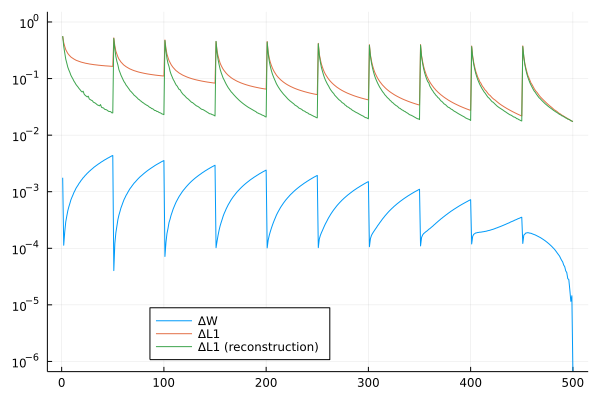

In [329]:
ΔL1 = zero(ΔW)
ΔL1_recon = zero(ΔW)
ΔL2 = zero(ΔW)
ΔL∞ = zero(ΔW)
for i in eachindex(ΔL1)
    ΔL1[i] = norm(sᵣ_pdf[i] - S₁[:,i], 1) * Δx
    ΔL1_recon[i] = norm(sₑ_pdf[i] - S₁[:,i], 1) * Δx
    ΔL2[i] = norm(sᵣ_pdf[i] - S₁[:,i], 2) * Δx
    ΔL∞[i] = maximum(abs.(sᵣ_pdf[i] - S₁[:,i]))
end

plot([ sqrt.(abs.(ΔW)),  
        ΔL1,
        ΔL1_recon,  
        #ΔL2 .+ 1e-6  #=,ΔL∞ .+ 1e-6
        ],
        yaxis = :log, label = ["ΔW" "ΔL1" "ΔL1 (reconstruction)"], legend = :bottom, ylimits=[1e-6,1])

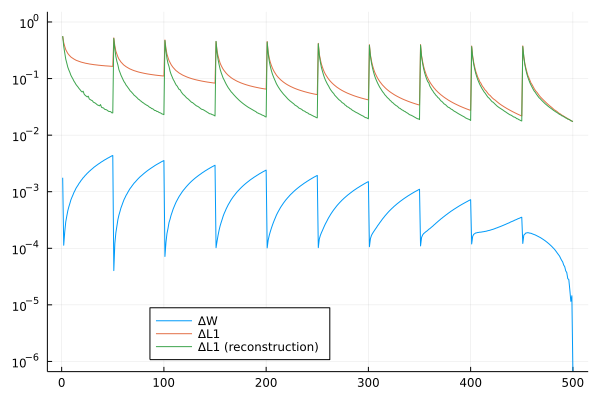

In [330]:
plot([ sqrt.(abs.(ΔW)),  
        ΔL1,
        ΔL1_recon,  
        #ΔL2 .+ 1e-6  #=,ΔL∞ .+ 1e-6
        ],
        yaxis = :log, label = ["ΔW" "ΔL1" "ΔL1 (reconstruction)"], legend = :bottom, ylimits=[1e-6,1])

# POD

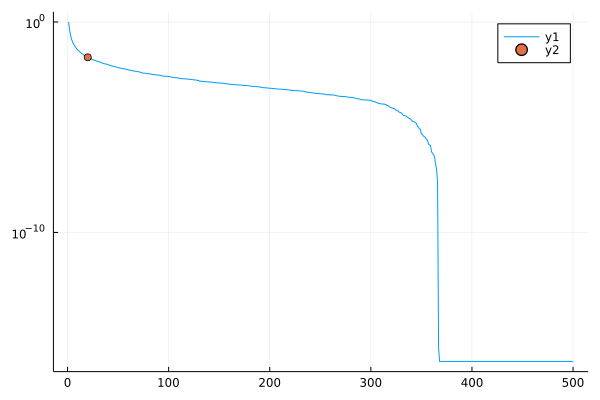

In [9]:
U, Σ, Vᵀ = svd(S₁);
plot(Σ./Σ[1], yaxis=:log)
scatter!([20],[Σ[20]/Σ[1]])

In [15]:
n_pod = 50
Ψ = U[:,1:n_pod]
sᵣ_pdf_pod = [Ψ*Ψ'*S₁[:,i] for i in 1:nₜₚ];
n_pod

50

In [18]:
iₑₓ = 450
gr();
plot(xgrid, S₁[:,iₑₓ], label="ground truth",xlabel="x",ylabel="s",linewidth=2)
plot!(xgrid,sᵣ_pdf_pod[iₑₓ], label="POD reconstruction (n=$n_pod)",linewidth=2,legendfontsize=10)
savefig("../pictures/svd_example.png")

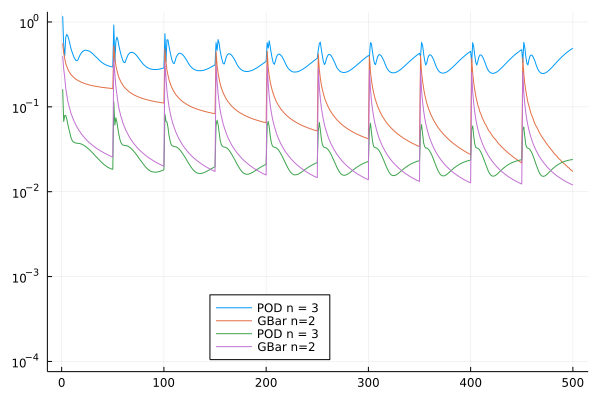

In [334]:
ΔL1_pod = zero(ΔW)
ΔL2_pod = zero(ΔW)
for i in eachindex(ΔL1)
    ΔL1_pod[i] = norm(sᵣ_pdf_pod[i] - S₁[:,i], 1) * Δx
    ΔL2_pod[i] = norm(sᵣ_pdf_pod[i] - S₁[:,i], 2) * Δx
end

plot([ ΔL1_pod, 
        ΔL1,
        ΔL2_pod, 
        ΔL2], yaxis = :log, ylimits=[1e-4,1], label = ["POD n = $n_pod" "GBar n=$n"], legend = :bottom)

In [335]:
p = plot(xgrid,Ψ[:,1])
for i in 2:5
    plot!(xgrid,Ψ[:,i])
end
p

LoadError: [91mBoundsError: attempt to access 1000×3 Array{Float64,2} at index [1:1000, 4][39m

# GREEDY

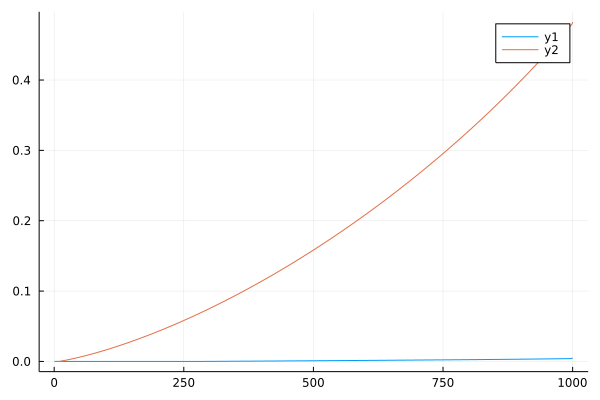

In [121]:
a_0 = copy(a)
plot(a)

In [122]:
a_g = copy(a_0);
basis_index = [maxD[2], maxD[1]]

2-element Array{Int64,1}:
   1
 500

In [123]:
function greedy_algo!(s, a, Δx, basis_index; tol=1e-6, rtol=1e-2, max_iter=25)
    
    n = length(a)
    k = length(s)
    Λ = [[zeros(n) for _ in 1:k] for _ in 1:max_iter]
    ΔW = [zeros(k) for _ in 1:max_iter]
    Λ_int = [zeros(n) for _ in 1:k]
    ΔW_int = zeros(k)
    iter=1
    ΔW_max = [];
    reason=0
    
    while iter<max_iter
        result = MorporJ.barycenter_fit(s, a, Δx)
        Λ_int .= result[1]
        ΔW_int .= result[2]
        epsi=maximum(ΔW_int)
        push!(ΔW_max, epsi)
        Λ[iter].=Λ_int 
        ΔW[iter].=ΔW_int
        print("Current W2 error: $epsi \n")
        if iter !=1 && abs(ΔW_max[end-1] - epsi)/ΔW_max[end-1] < rtol
            reltol_met=( ΔW_max[end-1] - epsi)/ΔW_max[end-1]
            print("rtol not met - $reltol_met \n")
            pop!(basis_index) # remove last basis addition that didnt substantially improve the fit
            pop!(a)
            reason=1
            break
        elseif epsi<tol
            print("atol met")
            reason=2
            break
        else
            i_star=argmax(ΔW_int)
            print("Adding snapshot number: $i_star \n")
            push!(a, s[i_star])
            push!(basis_index, i_star)
        end
        iter+=1
        if iter==max_iter
            result = MorporJ.barycenter_fit(s, a, Δx)
            Λ_int .= result[1]
            ΔW_int .= result[2]
            epsi=maximum(ΔW_int)
            push!(ΔW_max, epsi)
            Λ[iter].=Λ_int 
            ΔW[iter].=ΔW_int
            reason=3
        end
    end
    
    return Λ, ΔW, ΔW_max, a, basis_index, reason, iter
end

greedy_algo! (generic function with 4 methods)

In [124]:
Resss=greedy_algo!(s, a_g, Δx, basis_index; tol=1e-6);

Current W2 error: 1.9060289057175043e-5 
Adding snapshot number: 50 
Current W2 error: 3.683824390860786e-8 
atol met

In [125]:
reason=Resss[6];
iter_fin=Resss[7];
if reason==1
    Λ_g=Resss[1][1:iter_fin-1];
    ΔW_g=Resss[2][1:iter_fin-1];
elseif reason==2 || reason==3
    Λ_g=Resss[1][1:iter_fin];
    ΔW_g=Resss[2][1:iter_fin];
end
ΔW_max=Resss[3];
a_g=Resss[4];
basis_index_g=Resss[5];

Dict_reason = Dict(0 => "No greedy", 1 => "Relative Tolerance", 2 => "Absolute Tolerance", 3=> "Maximum number of iterations")
println("Reason to stop greedy algorithm: ", Dict_reason[reason])

Reason to stop greedy algorithm: Absolute Tolerance


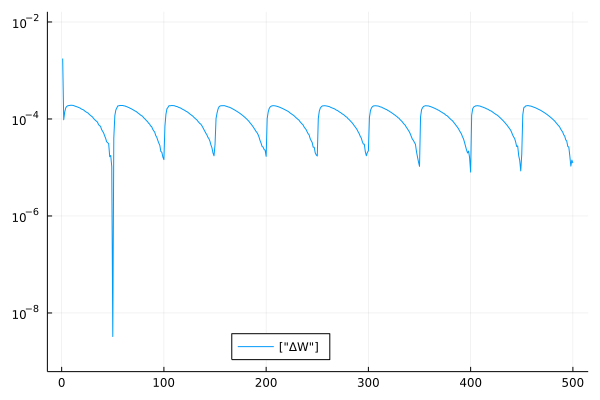

In [126]:
plot(ΔW_g[end], legend=:topleft) # .+ 1e-11
plot([ sqrt.(abs.(ΔW_g[end]))],
        yaxis = :log, label = ["ΔW"], legend = :bottom, ylimits=[1e-9,1e-2])

In [127]:
n_g=length(a_g)

3

Reconstruction

In [128]:
sᵣ_g = [zeros(M) for i in 1:nₜₚ]
for j in 1:nₜₚ
    for i in 1:n_g
        sᵣ_g[j] .+= Λ_g[end][j][i] .* a_g[i] # u approx
    end
end
sᵣ_g_cdf = [zeros(N) for i in 1:nₜₚ]
sᵣ_g_pdf = [zeros(N) for i in 1:nₜₚ]

for j in 1:nₜₚ
    MorporJ.iicdf!(sᵣ_g_cdf[j], sᵣ_g[j], xgrid, pgrid)
    MorporJ.cdf_to_pdf!(sᵣ_g_pdf[j], sᵣ_g_cdf[j], Δx; order=1)
end


In [129]:
Λ_g[end][187]

3-element Array{Float64,1}:
 0.29372458310691135
 0.30808390126730256
 0.39819151562532995

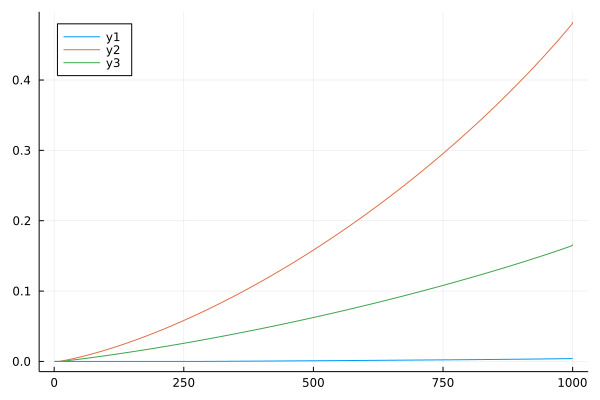

In [130]:
plot(sᵣ_g[basis_index_g], legend=:topleft)

In [131]:
#plot(sᵣ_g_pdf[basis_index_g[1:2]],ylim=[0, 10],xlim=[0, 20])

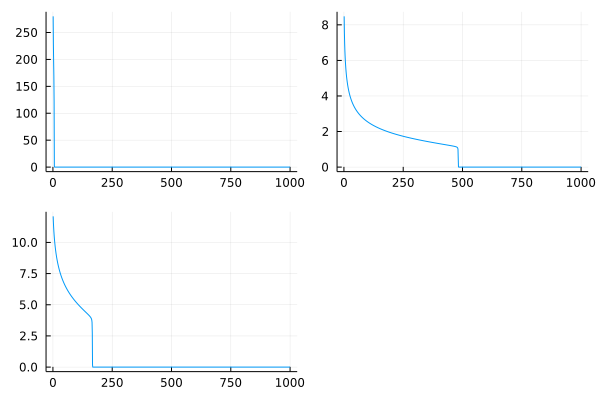

In [132]:
plot(S₁[:,basis_index_g],layout=n_g,legend=:none)

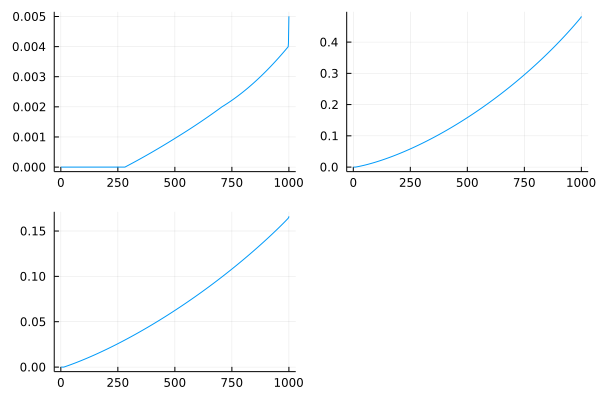

In [133]:
plot(a_g,layout=n_g,legend=:none)

In [134]:
ΔL1_g = zero(ΔW_g[end])
ΔL2_g = zero(ΔW_g[end])
ΔL∞_g = zero(ΔW_g[end])
for i in eachindex(ΔL1)
    ΔL1_g[i] = norm(sᵣ_g_pdf[i] - S₁[:,i], 1) * Δx
    ΔL2_g[i] = norm(sᵣ_g_pdf[i] - S₁[:,i], 2) * Δx
    ΔL∞_g[i] = maximum(abs.(sᵣ_g_pdf[i] - S₁[:,i]))
end


In [269]:
plot([ sqrt.(abs.(ΔW_g[end])),  
        ΔL1_g,
        ΔL1_recon,  
        #ΔL2 .+ 1e-6  #=,ΔL∞ .+ 1e-6
        ],
        yaxis = :log, label = ["ΔW" "ΔL1" "ΔL1 (reconstruction)"], xlabel="(μ,t)ⱼ₌₁...ₙₚ", legend = :bottom, ylimits=[1e-6,1])
#savefig("../pictures/greedy_errors.png")

In [164]:
n_g

3

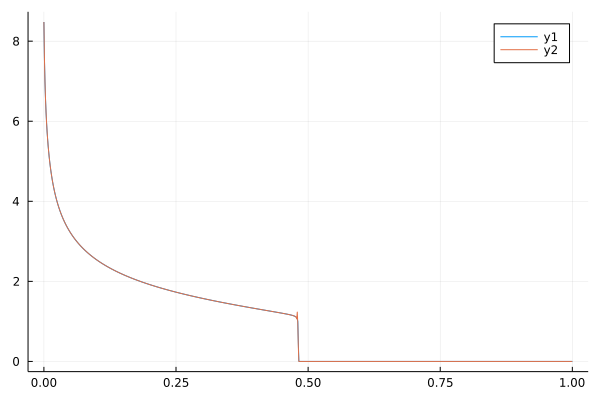

In [136]:
idx = 500
plot(xgrid, [S₁[:,idx] sᵣ_g_pdf[idx]])

In [183]:
#plot(1:nₜₚ, hcat(ΔW_g[end].+ 1e-15,ΔL1_g.+ 1e-15,ΔL2_g.+ 1e-15), label = ["ΔW" "L1" "L2"], layout = (3, 1),legend=:topleft)
sqrt.(ΔW_max)

2-element Array{Float64,1}:
 0.004365809095365376
 0.0001919329151255924

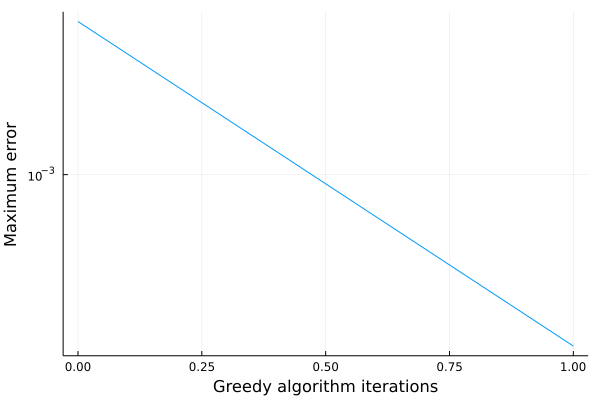

┌ Warning: No strict ticks found
└ @ PlotUtils /home/tobias/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295
┌ Warning: No strict ticks found
└ @ PlotUtils /home/tobias/.julia/packages/PlotUtils/n4I4Q/src/ticks.jl:295


In [182]:
gr();
plot(0:(n_g-2), sqrt.(ΔW_max), yaxis=:log, xlabel="Greedy algorithm iterations",ylabel="Maximum error",legend=:none)
#savefig("C:\\Users\\DIMEAS1759\\Desktop\\UB\\CEMRACS2021\\pictures\\max_error_greedy.png")

In [143]:
basis_index_g

3-element Array{Int64,1}:
   1
 500
  50

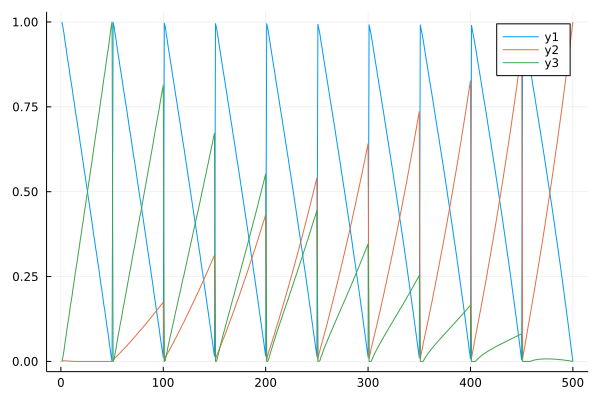

In [144]:
p = plot([Λ_g[end][i][1] for i in eachindex(Λ_g[end])] )
for j in 2:size(Λ_g[end][1],1)
    plot!([Λ_g[end][i][j] for i in eachindex(Λ_g[end])] )
end
p

# Interpolations

In [156]:
nodes = (collect(0.1:0.1:5), 1.0*mu_ratio);
lambda_vec_vec = [ [Λ_g[end][i][j] for i in eachindex(Λ_g[end])] for j in 1:n_g];
mass = zeros(nₜₚ)
for i in eachindex(mass)
    mass[i] = sum(S[:,i])*Δx
end
mass = reshape(mass, (50,10));


In [146]:
lambda_mat_vec = [zeros(50,10) for j in 1:n_g];

In [147]:
for i in 1:n_g
    lambda_mat_vec[i] = reshape(lambda_vec_vec[i], (50,10))
end

In [158]:
itp = [interpolate(nodes, lambda_mat_vec[i], Gridded(Linear())) for i in 1:n_g];
mass_itp = interpolate(nodes, mass, Gridded(Linear()));

In [268]:
gr();
surface(10:1:100, 0.1:0.01:5, mass_itp(0.1:0.01:5,10:1:100), ylabel="t", xlabel="μ",zlabel="∫s",camera=(60,60))
#savefig("../pictures/mass_interp.png")


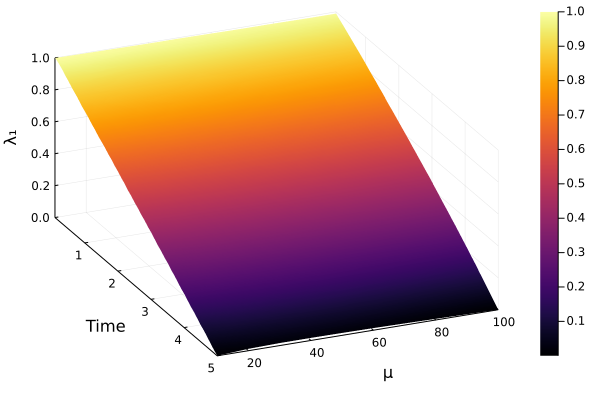

In [149]:
surface( 0.1:0.01:5, 10:1:100, itp[1](0.1:0.01:5,10:1:100)', ylabel="μ", xlabel="Time",zlabel="λ₁",zlim=[0, 1],camera=(60,60))
#savefig("C:\\Users\\DIMEAS1759\\Desktop\\UB\\CEMRACS2021\\pictures\\first_coeff.png")

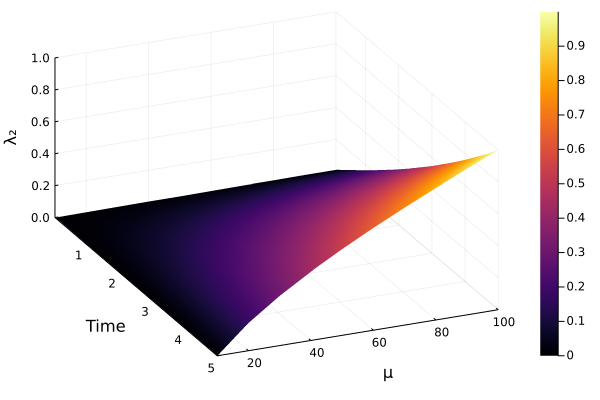

In [150]:
surface( 0.1:0.01:5, 10:1:100, itp[2](0.1:0.01:5,10:1:100)', ylabel="μ", xlabel="Time",zlabel="λ₂",zlim=[0, 1],camera=(60,60))
#savefig("C:\\Users\\DIMEAS1759\\Desktop\\UB\\CEMRACS2021\\pictures\\second_coeff.png")

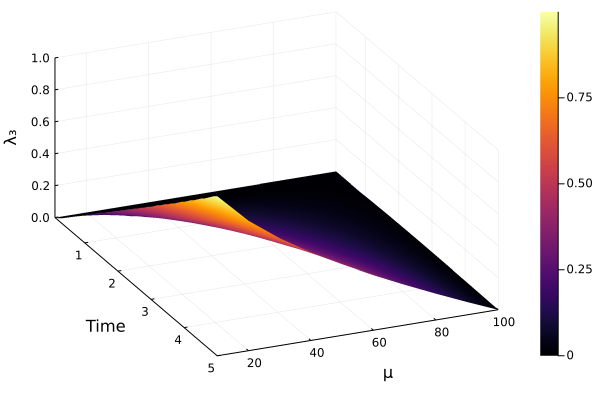

In [151]:
surface( 0.1:0.01:5, 10:1:100, itp[3](0.1:0.01:5,10:1:100)', ylabel="μ", xlabel="Time",zlabel="λ₃",zlim=[0, 1],camera=(60,60))
#savefig("C:\\Users\\DIMEAS1759\\Desktop\\UB\\CEMRACS2021\\pictures\\third_coeff.png")

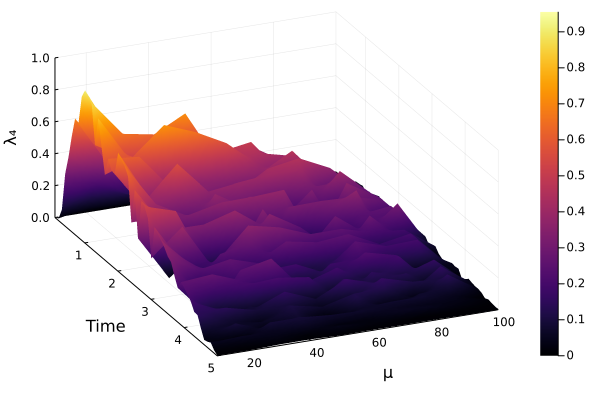

In [118]:
surface( 0.1:0.01:5, 10:1:100, itp[4](0.1:0.01:5,10:1:100)', ylabel="μ", xlabel="Time",zlabel="λ₄",zlim=[0, 1],camera=(60,60))


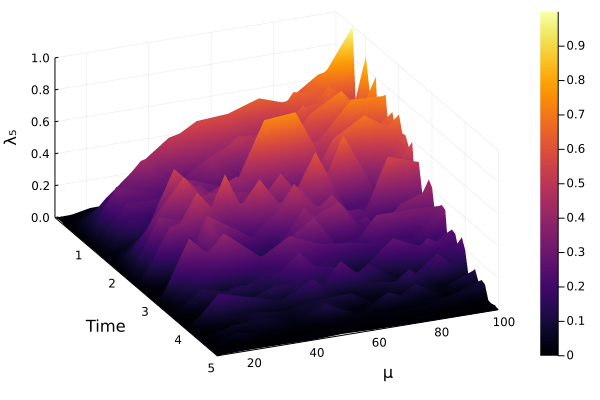

In [119]:
surface( 0.1:0.01:5, 10:1:100, itp[5](0.1:0.01:5,10:1:100)', ylabel="μ", xlabel="Time",zlabel="λ₅",zlim=[0, 1],camera=(60,60))


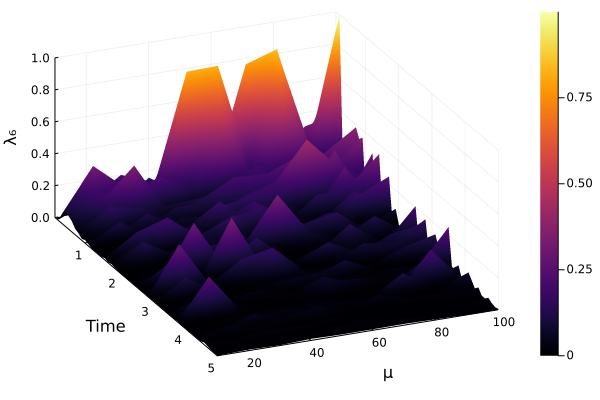

In [120]:
surface( 0.1:0.01:5, 10:1:100, itp[6](0.1:0.01:5,10:1:100)', ylabel="μ", xlabel="Time",zlabel="λ₆",zlim=[0, 1],camera=(60,60))


Video snapshots

In [73]:
fid = h5open("../../tests/data_snapshots_video.h5", "r")
A=[]
exponent_video = 2
mu_ratio_video=20
g=read(fid, "snap_mu_$(mu_ratio_video)")
dset = g["snap_exp_$(exponent_video)"]
push!(A,dset')

S=hcat([A[i] for i in 1:length(A)]...)
Nx=size(S,1)
Ns=size(S,2)
println(size(S))
close(fid)



(1000, 201)


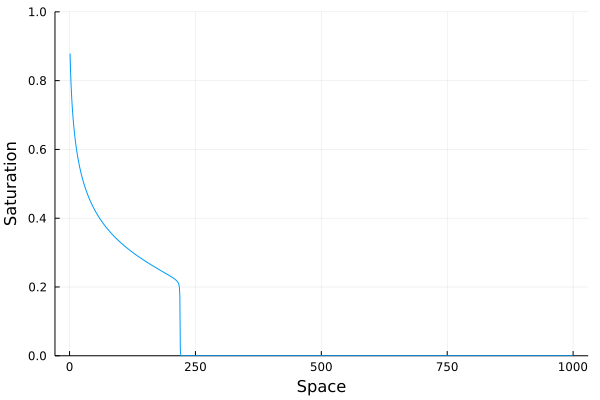

In [74]:
plot(S[:,51],ylims=(0, 1), xlabel="Space", ylabel="Saturation", legend=:none)

In [87]:
# anim = @animate for i ∈ 1:Ns
#     plot(S[:,i], ylims=(0, 1), xlabel="Space", ylabel="Saturation", legend=:none)
# end
# gif(anim, "anim_fps15.gif", fps = 10)

In [ ]:
plot(xgrid, [S[:,idx] sᵣ_g_pdf[idx]])

In [223]:
function reconstruct_s!(s, t, mu)
    tmp = zero(s)
    Λ_r = zeros(n_g)
    mass_r = mass_itp(t,mu)
    for i in 1:n_g
        s .+= itp[i](t,mu) .* a_g[i] # u approx
    end
    MorporJ.iicdf!(tmp, s, xgrid, pgrid)
    MorporJ.cdf_to_pdf!(s, tmp, Δx; order=1)
    s .*= mass_r
end

reconstruct_s! (generic function with 1 method)

In [293]:
t_recon = collect(0.1:0.1:5)
s_recon = [zeros(N) for _ in t_recon]
mu_recon = 87.5 #round( 10 + rand()*90, digits=1)
for i in eachindex(s_recon)
    reconstruct_s!(s_recon[i], t_recon[i], mu_recon)
end

μ₋ = floor(mu_recon/10 )*10
μ₊ = ceil(mu_recon/10 )*10
i₋ = 50*Int(floor(mu_recon/10)-1)
i₊ = 50*Int(ceil(mu_recon/10)-1)
#=
μ₋ = 10
μ₊ = 100
i₋ = 0
i₊ = 450  
=# 

   

400

In [294]:
mu_recon

87.5

┌ Info: Saved animation to 
│   fn = /home/tobias/Documents/IPP/CIRM/MorporJ/notebooks/s_recon.gif
└ @ Plots /home/tobias/.julia/packages/Plots/HcxwM/src/animation.jl:114


Plots.AnimatedGif("/home/tobias/Documents/IPP/CIRM/MorporJ/notebooks/s_recon.gif")
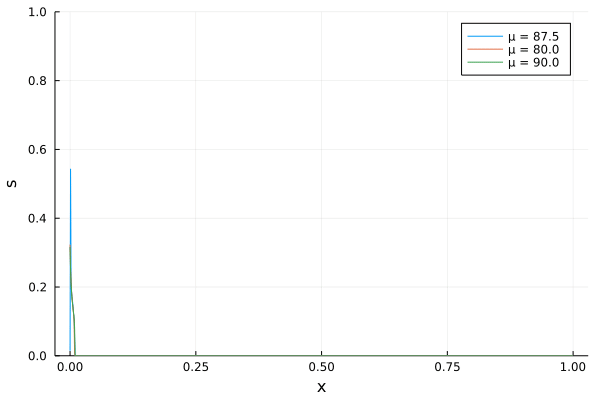

In [295]:
anim = @animate for i in eachindex(s_recon)
    plot(xgrid, [s_recon[i] S[:,i₋+i] S[:,i₊+i] ], ylims=(0, 1), xlabel="x", ylabel="s",
             legend=:topright, label=["μ = $mu_recon" "μ = $μ₋" "μ = $μ₊"])
end
gif(anim, "s_recon.gif", fps = 5)

#plot(xgrid, s_recon)

In [296]:
mu_ratio

10-element Array{Int64,1}:
  10
  20
  30
  40
  50
  60
  70
  80
  90
 100